### LITTLE EYES V4
#### Meu Quarto Modelo de Visão Computacional
Validação cruzada / controle de parada para selecionar o modelo mais genérico


In [1]:
# NETWORK
the_seed = 32
digit_size = (28, 28, 1)
convnn_acivation = 'relu'
fully_connected_acivation = 'tanh'
hyperparameter_max = 5
learning_rate = 0.01
patience = 5
max_epochs = 10 * patience
score_metric = 'accuracy'
verbose = 1
batch_size = None

# VALIDATION
n_folds = 3

In [2]:
import tensorflow
from tensorflow.keras import datasets, layers, models, optimizers, Input, Model
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot
import numpy
import pandas
import random
from sklearn.model_selection import StratifiedKFold
from seaborn import boxplot
from sklearn.metrics import accuracy_score

In [3]:
random.seed(the_seed)
numpy.random.seed(the_seed)
tensorflow.random.set_seed(the_seed)

In [4]:
def create_litle_eyes(digit_size : tuple[int, int, int] = (28, 28, 1),
                      convnn_acivation : str = 'relu',
                      fully_connected_acivation : str = 'tanh',
                      net_name : str = 'LittleEyes',
                      hyperparameter : int = 1):
    # CAMADA OCULTA
    inputs = Input(shape=digit_size)

    # PRIMEIRA CAMADA CONVOLUCIONAL
    conv_2d_layer_1 = layers.Conv2D(2 * hyperparameter, (3, 3), activation = convnn_acivation)
    x = conv_2d_layer_1(inputs)

    # PRIMEIRA CAMADA MAX POOLING
    maxpool_1 = layers.MaxPooling2D((2, 2))
    x = maxpool_1(x)

    # SEGUNDA CAMADA CONVOLUCIONAL
    conv_2d_layer_2 = layers.Conv2D(4 * hyperparameter, (3, 3), activation = convnn_acivation)
    x = conv_2d_layer_2(x)

    # SEGUNDA CAMADA MAX POOLING
    maxpool_2 = layers.MaxPooling2D((2, 2))
    x = maxpool_2(x)

    # TERCEIRA CAMADA CONVOLUCIONAL
    conv_2d_layer_3 = layers.Conv2D(4 * hyperparameter, (3, 3), activation = convnn_acivation)
    x = conv_2d_layer_3(x)

    # TERCEIRA CAMADA MAX POOLING
    maxpool_3 = layers.MaxPooling2D((2, 2))
    x = maxpool_3(x)

    # FLATTEN
    flatten_layer = layers.Flatten()
    x = flatten_layer(x)

    # FULLY CONNECTED HIDDEN LAYER
    hidden_layer = layers.Dense(hyperparameter + 1, activation = fully_connected_acivation)
    x = hidden_layer(x)

    # OUTPUT LAYER
    output_layer = layers.Dense(10)
    outputs = output_layer(x)

    return Model(inputs = inputs, outputs = outputs, name = net_name)

In [5]:
(train_images, train_labels), (validation_images, validation_labels) = datasets.mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_images, validation_images = train_images / 255.0, validation_images / 255.0

In [6]:
result_list = []
kfolder = StratifiedKFold(n_splits = n_folds, random_state = the_seed, shuffle = True)
early_stopping = EarlyStopping(monitor = "val_loss", patience = patience, restore_best_weights = True, verbose = verbose) 
for hyperparameter in numpy.arange(1, hyperparameter_max + 1):
    for i, (train_index, validation_index) in enumerate(kfolder.split(train_images, train_labels)):
        print(f"Starting h: {hyperparameter} f: {i}")
        X_train, Y_train = train_images[train_index], train_labels[train_index]
        X_val, Y_val = train_images[validation_index], train_labels[validation_index]
        
        # NET NAME > Hyperparameter + Fold Number
        net_name = f"LittleEyes_{hyperparameter}_{i}"
        print(f"{net_name} training started...")
        
        little_eyes = create_litle_eyes(net_name = net_name, 
                                        hyperparameter = hyperparameter)
        
        opt = optimizers.Adam(learning_rate = learning_rate)
        
        little_eyes.compile(optimizer=opt ,
                    loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=[score_metric])

        history = little_eyes.fit(X_train, Y_train, epochs = max_epochs, 
                            validation_data=(X_val, Y_val), 
                            verbose = verbose,
                            batch_size = batch_size,
                            callbacks = [early_stopping])
        
        training_score = history.history[score_metric][-1]
        validation_score = history.history[f"val_{score_metric}"][-1]
        
        result_list.append((net_name, hyperparameter, i, training_score, validation_score, little_eyes, history))
        print(f"{net_name.upper()}: {100 * training_score:.0f}% TRAINING {score_metric.upper()} / {100 * validation_score:.0f}% VALIDATION {score_metric.upper()}")

Starting h: 1 f: 0
LittleEyes_1_0 training started...
Epoch 1/50
1250/1250 [==============================] - 13s 9ms/step - loss: 1.4270 - accuracy: 0.4504 - val_loss: 1.2028 - val_accuracy: 0.5354
Epoch 2/50
1250/1250 [==============================] - 12s 9ms/step - loss: 1.0893 - accuracy: 0.5915 - val_loss: 1.0691 - val_accuracy: 0.5871
Epoch 3/50
1250/1250 [==============================] - 11s 9ms/step - loss: 1.0014 - accuracy: 0.6350 - val_loss: 0.9710 - val_accuracy: 0.6786
Epoch 4/50
1250/1250 [==============================] - 13s 10ms/step - loss: 0.9499 - accuracy: 0.6743 - val_loss: 0.9535 - val_accuracy: 0.6520
Epoch 5/50
1250/1250 [==============================] - 9s 7ms/step - loss: 0.9036 - accuracy: 0.7079 - val_loss: 0.9137 - val_accuracy: 0.7278
Epoch 6/50
1250/1250 [==============================] - 11s 9ms/step - loss: 0.8730 - accuracy: 0.7229 - val_loss: 0.8414 - val_accuracy: 0.7479
Epoch 7/50
1250/1250 [==============================] - 14s 11ms/step - loss

In [7]:
results = pandas.DataFrame.from_records(result_list)
results.columns = ["net_name", 'hyperparameter', "kfold", score_metric, f"val_{score_metric}", "little_eyes", "history"]
results.sort_values("val_accuracy", ascending = False)

,net_name,hyperparameter,kfold,accuracy,val_accuracy,little_eyes,history
6,LittleEyes_3_0,3,0,0.953450,0.95145,<keras.engine.functional.Functional object at ...,<keras.callbacks.History object at 0x000002378...
8,LittleEyes_3_2,3,2,0.948925,0.94395,<keras.engine.functional.Functional object at ...,<keras.callbacks.History object at 0x000002378...
10,LittleEyes_4_1,4,1,0.949150,0.94360,<keras.engine.functional.Functional object at ...,<keras.callbacks.History object at 0x00000237B...
13,LittleEyes_5_1,5,1,0.936325,0.94360,<keras.engine.functional.Functional object at ...,<keras.callbacks.History object at 0x00000237B...
11,LittleEyes_4_2,4,2,0.935125,0.93715,<keras.engine.functional.Functional object at ...,<keras.callbacks.History object at 0x00000237B...
7,LittleEyes_3_1,3,1,0.936800,0.93160,<keras.engine.functional.Functional object at ...,<keras.callbacks.History object at 0x000002378...
9,LittleEyes_4_0,4,0,0.943325,0.92080,<keras.engine.functional.Functional object at ...,<keras.callbacks.History object at 0x000002378...
4,LittleEyes_2_1,2,1,0.910875,0.91455,<keras.engine.functional.Functional object at ...,<keras.callbacks.History object at 0x000002378...
14,LittleEyes_5_2,5,2,0.906675,0.90720,<keras.engine.functional.Functional object at ...,<keras.callbacks.History object at 0x00000237B...
12,LittleEyes_5_0,5,0,0.933325,0.90415,<keras.engine.functional.Functional object at ...,<keras.callbacks.History object at 0x00000237B...


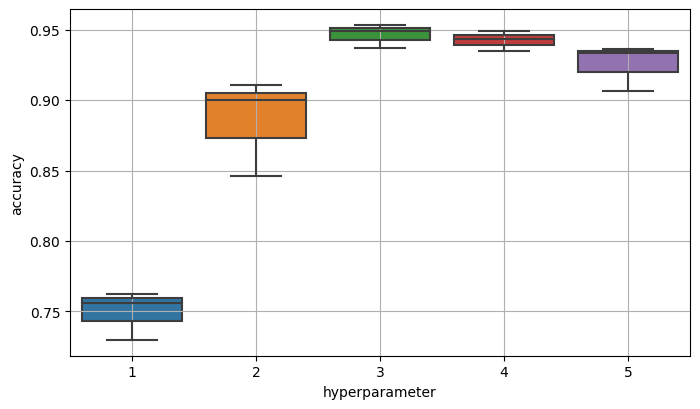

In [8]:
fig = pyplot.figure(figsize = (8, 4.5))
ax = fig.add_subplot(111)
boxplot(results, x = 'hyperparameter', y = 'accuracy', ax = ax)
ax.grid()

In [9]:
little_eyes = results.sort_values("val_accuracy", ascending = False).head(1)['little_eyes'].values[0]
little_eyes_history = results.sort_values("val_accuracy", ascending = False).head(1)['history'].values[0]
little_eyes

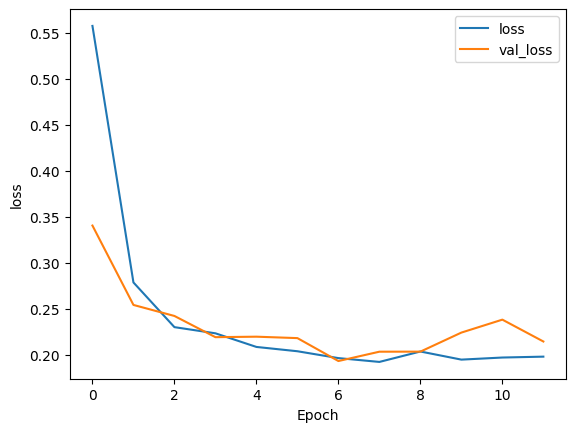

In [16]:
pyplot.plot(little_eyes_history.history['loss'], label='loss')
pyplot.plot(little_eyes_history.history['val_loss'], label = 'val_loss')
pyplot.xlabel('Epoch')
pyplot.ylabel('loss')
# pyplot.ylim([0.5, 1])
pyplot.legend(loc='upper right')

In [10]:
Y_test = little_eyes.predict(validation_images)

313/313 [==============================] - 1s 3ms/step


In [11]:
Y_predicted = numpy.argmax(Y_test, axis = 1)
Y_predicted

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

TRUE NUMBER: 2 >> PREDICTED NUMBER: 2


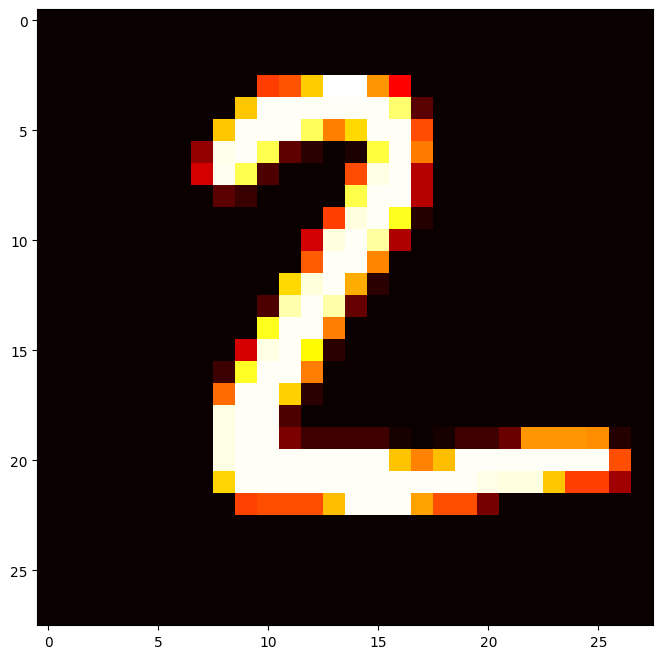

In [15]:
# TABAJARA VALIDATOR
image_id = 1
print(f"TRUE NUMBER: {validation_labels[image_id]} >> PREDICTED NUMBER: {Y_predicted[image_id]}")
# Y_test[image_id, :]
fig = pyplot.figure(figsize = (8, 8))
ax = fig.add_subplot(111)
_ = pyplot.imshow(validation_images[image_id], cmap='hot')

In [13]:
accuracy_score(validation_labels, Y_predicted)

0.9565